## Scraping Indian Restaurant Menus in New York City

As a graduate student living in New York City, I often miss food from home. Indian food is delicious and can be time consuming to make. Unfortunately for us, the courseload at the J school means we rarely get time to cook Indian food. That leaves us with one option. Eating outside. 

New York City is one of the world's most diverse cities for cuisine and there's no dearth of Indian restaurants. Jackson Heights and Murray Hill are neighbourhoods associated with Indian food. Are there other neighbourhoods too? What foods are most common on Indian restaurant menus, how diverse are there cuisines? Do they have dosas on their menu? This notebook is an attempt to try finding that out


### Using YelpAPI Package to get a list of Indian Restaurants

In [ ]:
!pip install yelpapi

In [53]:
from yelpapi import YelpAPI
yelp_api = YelpAPI("LXyVZADiCFd7MjmUBeGBk8WcUKqJN8biDN_dErjcqIrhlZ-Q6jpl4Xs6SV9lADJQFW6oSa4zHK9FhKFIwT-dolv2Z-TAfnkGDX2VLynXud9NMtTVUOmwvPhQjh_zYXYx") #Removed my API key


Using the Yelp API package, it is possible to look up Indian restaurants in New York City region. The Yelp API has a limit of 50 restaurants at one go. And can return only a 1000 results at max about any query. We run a query to see if the API is working 

In [55]:
response = yelp_api.search_query(term='indian', location='nyc', price=1, limit=50)
tempjson=response['businesses']
df = pd.DataFrame(tempjson)

In [56]:
df.head(2)

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,mZALre3ahuetu5X8_uUJew,thelewala-new-york,Thelewala,https://s3-media3.fl.yelpcdn.com/bphoto/FRhVuR...,False,https://www.yelp.com/biz/thelewala-new-york?ad...,503,"[{'alias': 'indpak', 'title': 'Indian'}]",4.0,"{'latitude': 40.72963, 'longitude': -74.00068}","[pickup, delivery]",$,"{'address1': '112 Macdougal St', 'address2': '...",+12126149100,(212) 614-9100,2737.940195
1,NhBUzlITbu3rdjm9UEfWsw,rajs-indian-kitchen-long-island-city-28,Raj's Indian Kitchen,https://s3-media4.fl.yelpcdn.com/bphoto/wkQFHx...,False,https://www.yelp.com/biz/rajs-indian-kitchen-l...,299,"[{'alias': 'indpak', 'title': 'Indian'}]",4.0,"{'latitude': 40.74956171352732, 'longitude': -...","[pickup, delivery]",$,"{'address1': '42-12 28th St', 'address2': '', ...",+17183618844,(718) 361-8844,6733.921400


We get the name, location, price range, coordinates, categories, rating, number of reviews etc about the restaurants. 

Yelp has a limit of a thousand restaurants, which is a bummer. So I cheat by using various kinds of search queries : rating, price etc to find out as many indian restaurants I can extract. I repeat the above code with various parameters to eventually end up discovering that Yelp has a 1015 restaurants in New York City area that are tagged as Indian. The Department of Health and Sanitation tells us there are 6,000 odd restaurants in the city - so this is obviously not representative, but is as good as it can get. 

In [ ]:
for count in range(1,21):
    offsetcount=(50*count+1)
    print(offsetcount)
    response = yelp_api.search_query(term='indian', location='nyc', price=1, limit=50, offset=offsetcount)
    tempjson=response['businesses']
    tempdf= pd.DataFrame(tempjson)
    df=df.append(tempdf)

These restaurants are all aggregated in Excel manually and are ready to go. 

In [58]:
newdf=pd.read_csv("cleaneduprestaurants.csv")

The Yelp API gives you some details but it does not tell you what items are on the menu. For this activity, I had to write a selenium script that looked up the URLs of these restaurants, checked if they had an online menu, and then collected a list of the items on the menu and their price. 

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import glob
import time
import re
import json
from pandas import json_normalize


from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import Select

from webdriver_manager.chrome import ChromeDriverManager

import tika
tika.initVM()
from tika import parser

In [3]:
newdf.head(3)

,Unnamed: 0,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,0,_7BGw3YFNOTzP1Www3zB7g,mughlai-grill-new-york,Mughlai Grill,https://s3-media2.fl.yelpcdn.com/bphoto/lO0eDO...,False,https://www.yelp.com/biz/mughlai-grill-new-yor...,427,"[{'alias': 'indpak', 'title': 'Indian'}]",4.5,"{'latitude': 40.7210905, 'longitude': -73.9840...","['restaurant_reservation', 'pickup', 'delivery']",$$,"{'address1': '6 Clinton St', 'address2': '', '...",1.212533e+10,(212) 533-2828,1942.354079
1,1,zyQpS4QrYYB0VKXf7JPUlQ,atithi-indian-cuisine-brooklyn,Atithi Indian Cuisine,https://s3-media1.fl.yelpcdn.com/bphoto/1HW_F-...,False,https://www.yelp.com/biz/atithi-indian-cuisine...,95,"[{'alias': 'indpak', 'title': 'Indian'}]",5.0,"{'latitude': 40.714765, 'longitude': -73.961606}","['restaurant_reservation', 'pickup', 'delivery']",$$,"{'address1': '159 Grand St', 'address2': None,...",1.718685e+10,(718) 684-9192,2948.013206
2,2,x0k5kFArHLijdY8-NEQ7Xg,bengal-tiger-indian-food-new-york,Bengal Tiger Indian Food,https://s3-media3.fl.yelpcdn.com/bphoto/UIX06N...,False,https://www.yelp.com/biz/bengal-tiger-indian-f...,2072,"[{'alias': 'indpak', 'title': 'Indian'}]",4.5,"{'latitude': 40.763167, 'longitude': -73.977131}","['pickup', 'delivery']",$$,"{'address1': '58 W 56th St', 'address2': 'Fl 2...",1.212265e+10,(212) 265-2703,6579.278643


In [4]:
import random
driver = webdriver.Chrome(ChromeDriverManager().install())



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Trying to download new driver from https://chromedriver.storage.googleapis.com/97.0.4692.71/chromedriver_win32.zip
Driver has been saved in cache [C:\Users\sriha\.wdm\drivers\chromedriver\win32\97.0.4692.71]


In [14]:
all_the_data=[]
for row in newdf.iterrows():
    waittime = random.randint(3,5)
    deets={}
    restaurant_id = row[1]['id']
    restaurant_name = row[1]['name']
    deets['name'] = restaurant_name
    deets['id'] = restaurant_id
    deets['menu'] = "No menu found"
    url="https://www.yelp.com/menu/"+row[1]['alias']
    driver.get(url)
    time.sleep(waittime)
    print(url)
    try: 
        all_items_on_menu={}
        menu_items=driver.find_elements_by_class_name("arrange")
        for item in menu_items:
            dish = item.find_element_by_tag_name('h4').text
            try: 
                price=item.find_element_by_class_name("menu-item-price-amount").text
                all_items_on_menu[dish]=price 
            except:
                all_items_on_menu[dish]="No price"
    except:
        pass
    deets['menu']=all_items_on_menu
    all_the_data.append(deets)

https://www.yelp.com/menu/vegetarian-palate-brooklyn
https://www.yelp.com/menu/windies-restaurant-and-bar-queens-village
https://www.yelp.com/menu/sagar-chinese-jamaica-jamaica
https://www.yelp.com/menu/fine-buffet-indian-restaurant-queens
https://www.yelp.com/menu/dakshin-express-edison
https://www.yelp.com/menu/bawarchi-biryani-corner-edison-2
https://www.yelp.com/menu/chopstick-edison-5
https://www.yelp.com/menu/shezan-restaurant-and-banquet-hall-edison
https://www.yelp.com/menu/shalimar-restaurant-iselin
https://www.yelp.com/menu/sukhadias-fresh-kitchen-and-indian-bistro-iselin
https://www.yelp.com/menu/afghan-kebab-and-grill-jackson-heights
https://www.yelp.com/menu/mirchi-pizza-and-sweets-edison
https://www.yelp.com/menu/dakshin-indian-cuisine-iselin
https://www.yelp.com/menu/egg-delight-edison
https://www.yelp.com/menu/bombay-spice-i-iselin-3


The initial scraper was written in BS4 and that got my ISP blocked at home, and at Columbia. So I rewrote it with Selenium and it worked perfectly. However, I was constantly moving between home and campus, so had to run this scraper in pieces. Each piece was saved as a CSV that I manually merged to make one huge CSV of list of restaurant menus

In [15]:
pd.DataFrame(all_the_data).to_csv("menudeets9.csv")

Once cleaned up, I had the 1015 restaurants on Yelp tagged Indian and a list of the food on their menus. 

In [2]:
df = pd.read_csv("finallistofrestaurants.csv")

In [3]:
df.head()

,name,id,menu
0,Mughlai Grill,_7BGw3YFNOTzP1Www3zB7g,"{'Malbec': '$32.00', 'Cabernet': '$28.00', 'Ma..."
1,Bengal Tiger Indian Food,x0k5kFArHLijdY8-NEQ7Xg,"{'Saag Paneer': '$13.00', 'Chana Masala': '$13..."
2,Indian Table,BXoW0AUDE7WZJcY-Vhqlbg,"{'Lemon Grass Rasam Soup': '$9.00', 'Caldo Ver..."
3,Sathi,t6PzD4uzBOfyCLcd_lT8cQ,"{'Masala Chai': '$3.00', 'Mango Lassi': '$5.00..."
4,Malai Marke Indian Cuisine,7DUPGtHqVZHJ3yIufbWLsg,"{'Mulligatawny Soup': '$6.95', 'Rasam Soup': '..."


Long format is better to do analysis, so converted the wide format df where the menu was in a row, where each item got its own row. 

In [7]:
import ast

{'muffin': 'lolz', 'foo': 'kitty'}

In [38]:
all_the_data=[]
for row in df.iterrows():
    newdict=ast.literal_eval(row[1]['menu'])
    for key in newdict:
        deets={}
        deets['name'] = row[1]['name']
        deets['id'] = row[1]['id']
        deets['item'] = key
        deets['price'] = newdict[key]
        all_the_data.append(deets)

In [39]:
data = pd.DataFrame(all_the_data)

In [41]:
len(data)

82419

So we have 82419 items on the thousand odd menus in the city available from Yelp

In [42]:
data.to_csv("menudata.csv")

Because the same foods are spelt differently and there were inconsistencies in formatting, the data had to be cleaned using Open Refine. This step took quite sometime as indian restauranters do not agree on SPELLINGS of their dishes

In [60]:
df = pd.read_csv("menudata-csv.csv")

Let us take a look at what is the most popular dish on Indian restaurant menus

In [62]:
df['item'].value_counts().head(20)

Mango Lassi             358
Garlic Naan             342
Gulab Jamun             333
Rasmalai                317
Chicken Tikka Masala    315
Chicken Biryani         294
Chana Masala            269
Chicken Curry           236
Chicken Tikka           235
Soda                    234
Malai Kofta             233
Dal Makhani             232
Samosa Chaat            229
Vegetable Biryani       227
Aloo Paratha            222
Naan                    221
Lamb Biryani            215
Chicken Vindaloo        215
Mutter Paneer           213
Tandoori Chicken        211
Name: item, dtype: int64

In [65]:
top_50 = df['item'].value_counts().head(50).index.to_list()

In [66]:
top_50

['Mango Lassi',
 'Garlic Naan',
 'Gulab Jamun',
 'Rasmalai',
 'Chicken Tikka Masala',
 'Chicken Biryani',
 'Chana Masala',
 'Chicken Curry',
 'Chicken Tikka',
 'Soda',
 'Malai Kofta',
 'Dal Makhani',
 'Samosa Chaat',
 'Vegetable Biryani',
 'Aloo Paratha',
 'Naan',
 'Lamb Biryani',
 'Chicken Vindaloo',
 'Mutter Paneer',
 'Tandoori Chicken',
 'Lamb Vindaloo',
 'Aloo Gobi',
 'Mango Chutney',
 'Shrimp Biryani',
 'Bhindi Masala',
 'Chicken Korma',
 'Onion Kulcha',
 'Chili Chicken',
 'Paneer Tikka Masala',
 'Navratan Korma',
 'Raita',
 'Paneer Makhani',
 'Saag Paneer',
 'Palak Paneer',
 'Paratha',
 'Roti',
 'Butter Chicken',
 'Goat Curry',
 'Shrimp Curry',
 'Keema Naan',
 'Chicken Saag',
 'Goat Biryani',
 'Papadum',
 'Sweet Lassi',
 'Chili Paneer',
 'Mulligatawny Soup',
 'Tandoori Roti',
 'Lamb Curry',
 'Tandoori Shrimp',
 'Chana Saag']

In [68]:
short_df=df[df['item'].isin(top_50)]

In [69]:
short_df.to_csv("items.csv")

In [72]:
import plotnine

In [148]:
short_df = pd.read_csv("items.csv")

In [149]:
short_df.head()

,Unnamed: 0,Column,name,id,item,price,rating,reviews,category,category.1
0,23,23,Mughlai Grill,_7BGw3YFNOTzP1Www3zB7g,Samosa Chaat,6.95,4.5,427.0,$$,Mid-range
1,31,31,Mughlai Grill,_7BGw3YFNOTzP1Www3zB7g,Mulligatawny Soup,5.95,4.5,427.0,$$,Mid-range
2,38,38,Mughlai Grill,_7BGw3YFNOTzP1Www3zB7g,Chicken Saag,15.95,4.5,427.0,$$,Mid-range
3,39,39,Mughlai Grill,_7BGw3YFNOTzP1Www3zB7g,Chicken Tikka Masala,15.95,4.5,427.0,$$,Mid-range
4,40,40,Mughlai Grill,_7BGw3YFNOTzP1Www3zB7g,Chicken Vindaloo,15.95,4.5,427.0,$$,Mid-range


In [150]:
short_df = short_df[short_df['price']!="No price"]

In [151]:
short_df['price']=short_df['price'].astype(float)

In [152]:
short_df = short_df[short_df['category.1']!="Unknown"]

In [160]:
short_df.pivot_table(index='item',values='price',aggfunc='mean')

,price
item,
Aloo Gobi,12.427368
Aloo Paratha,4.565635
Bhindi Masala,13.011739
Butter Chicken,14.600217
Chana Masala,13.641506
Chana Saag,13.487168
Chicken Biryani,13.745097
Chicken Curry,14.469227
Chicken Korma,15.700750


In [170]:
list_order=top_50[::-1]

c:\users\sriha\appdata\local\programs\python\python39\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 26 rows containing missing values.


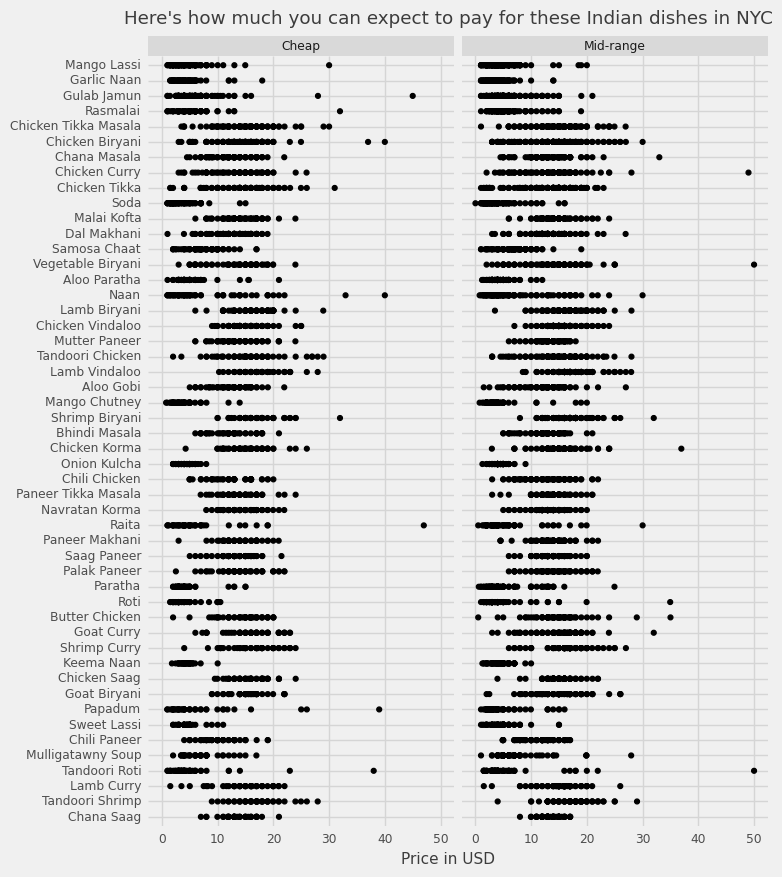

<ggplot: (125679337662)>

In [172]:
(
    ggplot(short_df,          # data
        aes('price', 'item')) # aesthetics
        + geom_point()     # geometry
        + scale_x_continuous(limits=(0, 50))
        + scale_y_discrete(limits=list_order)
        + facet_wrap('category.1')
        + theme_538()
        + labs(
            title = "Here's how much you can expect to pay for these Indian dishes in NYC",
            y = "",
            x = "Price in USD"
        )
        + theme(figure_size=(8, 10)
        )
)

c:\users\sriha\appdata\local\programs\python\python39\lib\site-packages\plotnine\scales\scale.py:102: PlotnineWarning: scale_y_discrete could not recognise parameter `order`
c:\users\sriha\appdata\local\programs\python\python39\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 26 rows containing missing values.


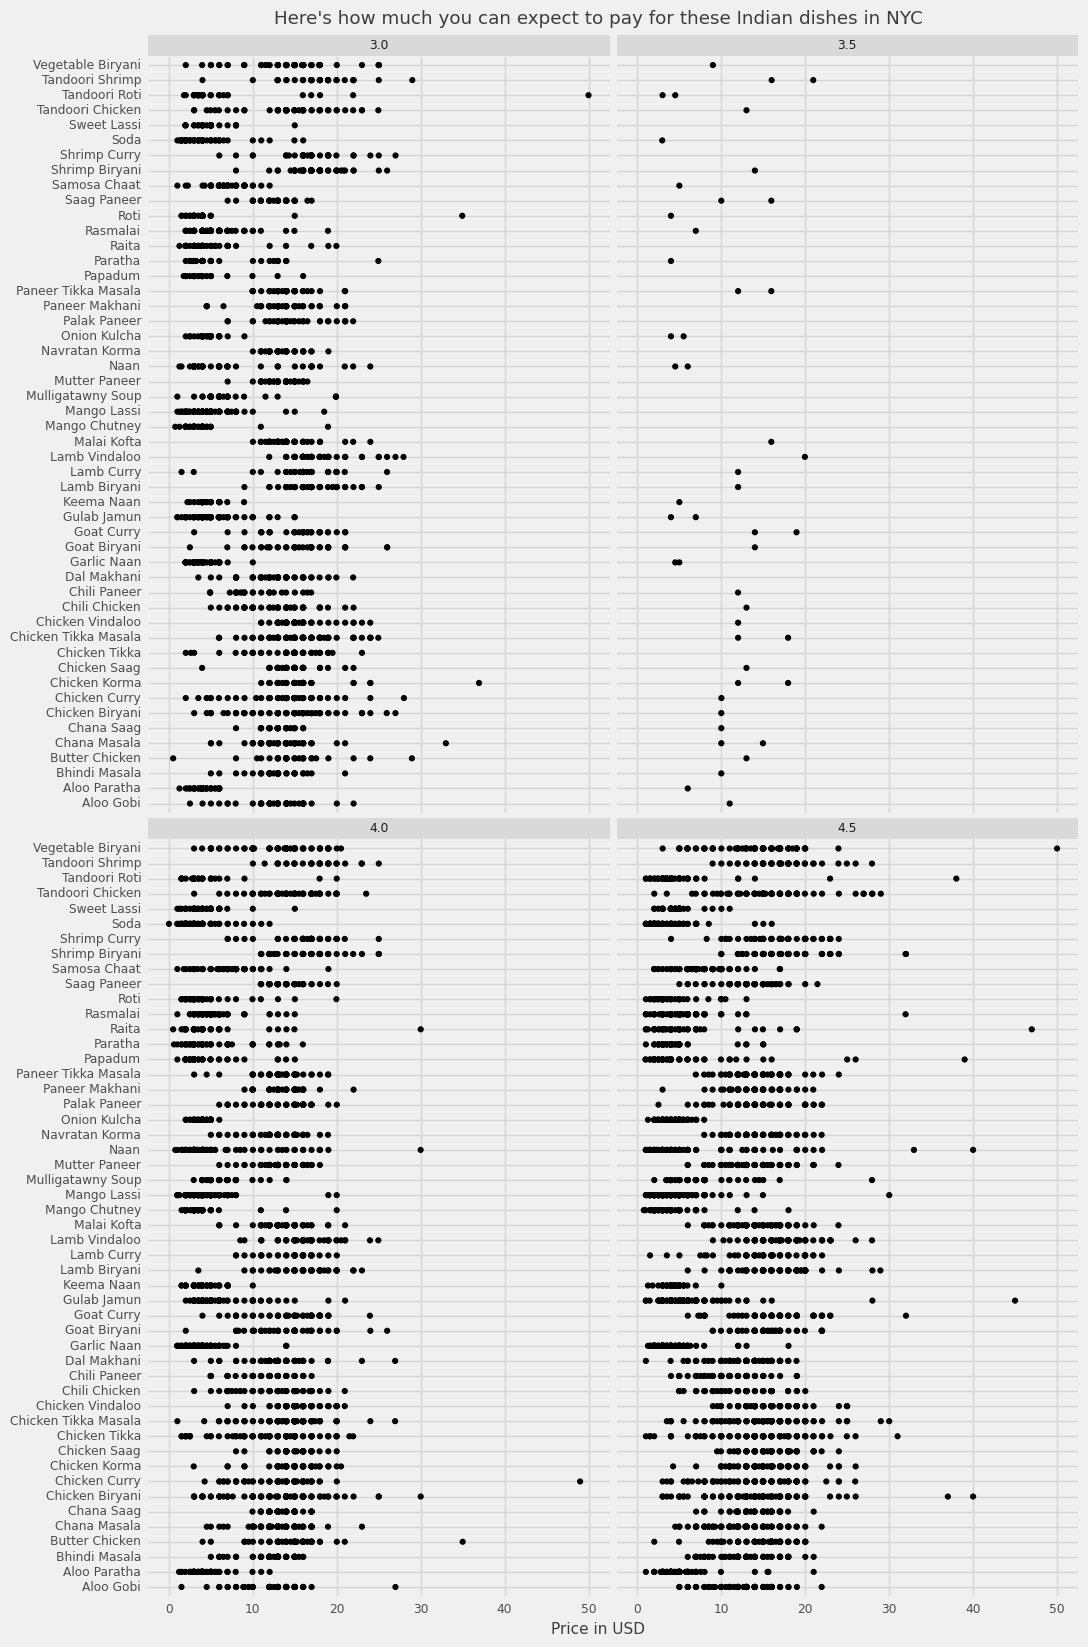

<ggplot: (125674999715)>

In [159]:
(
    ggplot(short_df,          # data
        aes('price', 'item')) # aesthetics
        + geom_point()     # geometry
        + scale_x_continuous(limits=(0, 50))
        + scale_y_discrete(order='count')
        + facet_wrap('rating')
        + theme_538()
        + labs(
            title = "Here's how much you can expect to pay for these Indian dishes in NYC",
            y = "",
            x = "Price in USD"
        )
        + theme(figure_size=(12, 20)
        )
)

Like I mentioned earlier, I'm from the South. I don't see any south indian dishes above except for Mulligatawny Soup. I'm looking for dosas, so lets go

In [175]:
for row in df.iterrows():
    if "dosa" in row[1]['item'].lower():
        print(row[1]['name'],row[1]['item'],row[1]['price'])

Ashoka on 2nd Avenue Masala Dosa 14
Ashoka on 2nd Avenue Plain Dosa 12
Ashoka on 2nd Avenue Rava Dosa 15
Ashoka on 2nd Avenue Mysore Masala Dosa 15
Ashoka on 2nd Avenue Paneer Dosa 15
Khiladi NYC Idly Nuggets (Podi Idly) For the Love of Dosa 27
Khiladi NYC Kickin Chicken Tikka For the Love of Dosa 31
Khiladi NYC For the Love of Dosa 14
Mint Masala Sada (Plain) Dosa 7.95
Mint Masala Masala Dosa 9.95
Mint Masala Mysore Sada Dosa 8.95
Mint Masala Mysore Masala Dosa 10.95
Mint Masala Maska Dosa 9.95
Mint Masala Maska Cheese Masala Dosa 12.95
Mint Masala Grilled Chicken Dosa 12.95
aRoqa Egg Dosa 15
aRoqa Dosa- Vegetarian 13
aRoqa Chicken Dosa 15
aRoqa Goat Keema & Egg Dosa 17
Ananda Sada Dosa 10.99
Ananda Paper Dosa 12.99
Ananda Paper Masala Dosa 14.99
Ananda Masala Dosa 13.99
Ananda Paneer Masala Dosa 15.99
Ananda Cheese Masala Dosa 15.99
Ananda Ghee Roast Masala Dosa 15.99
Ananda Gunpowder Sada Dosa 12.99
Ananda Gunpowder Masala Dosa 14.99
Ananda Paneer Bhurji Dosa 15.99
Ananda Mysore Sad

New Asha Sri Lanka Restaurant Masala Dosai 5
New Asha Sri Lanka Restaurant Egg Dosai 3.99
New Asha Sri Lanka Restaurant Oil Dosai 3
New Asha Sri Lanka Restaurant 4 Regular Plain Dosai 2.75
Cumin N Eat Plain Dosa 13
Cumin N Eat Ghee Dosa 11
Cumin N Eat Masala Dosa 11
Cumin N Eat Mysore Masala Dosa 12
Cumin N Eat Cheese Dosa 12
Cumin N Eat Paneer Masala Dosa 12
Cumin N Eat Egg Dosa 14
Spice Village Masala Dosa 11.95
Spice Village Plain Dosa 14.95
Spice Village Mysore Dosa 14.95
Calcutta Wrap & Roll Plain Dosa 5.99
Calcutta Wrap & Roll Masala Dosa 10.99
Calcutta Wrap & Roll Mysore Masala Dosa 10.99
Bukhara Grill:Indian Spice Rave Catering Dosa Balls 65
Samossa Bites 1Plain Dosa 4.99
Samossa Bites 2Masala Dosa 8.49
Samossa Bites 110Cheese Dosa 9.49
Samossa Bites 111Egg Dosa 7.49
Samossa Bites 112Cheese Egg Dosa 7.49
Samossa Bites 113Spinach Dosa 8.99
Samossa Bites 114Onion Dosa 7.49
Samossa Bites 11Chicken Dosa 6.49
Chef Of India Homemade Soft Dosa 9.99
Chef Of India Plain Dosa 7.99
Chef O

Bhoj Masala Dosa 7.5
Bhoj Mysore Masala Dosa 8.95
Bhoj Plain Dosa 5.95
Tamilnadu Cafe Sada (Plain) Dosa 8.99
Tamilnadu Cafe Masala Dosa 7.99
Tamilnadu Cafe Mysore Dosa 8.99
Tamilnadu Cafe Mysore Masala Dosa 8.99
Tamilnadu Cafe Chicken Tikka Dosa 9.99
Tamilnadu Cafe Muttai Dosa (Egg Dosa) 11.99
Grand Indian Restaurant Sada Dosai 3.95
Grand Indian Restaurant Masala Dosai 6.95
Grand Indian Restaurant Keema Dosai 7.95
Indian Taj Masala Dosa 3.95
Indian Taj Sada Dosa 8.95
Rani Mahal Indian Cuisine Masala Dosa 13.95
Rani Mahal Indian Cuisine Keema Dosa 16.95
Sapthagiri Taste Of India Sada Dosa 12.49
Sapthagiri Taste Of India Butter Sada Dosa 7.99
Sapthagiri Taste Of India Masala Dosa 8.99
Sapthagiri Taste Of India Butter Masala Dosa 8.99
Sapthagiri Taste Of India Paper Dosa 9.49
Sapthagiri Taste Of India Paper Masala Dosa 12.99
Sapthagiri Taste Of India Butter Paper Masala Dosa 12.99
Sapthagiri Taste Of India Onion Dosa 13.49
Sapthagiri Taste Of India Onion Masala Dosa 9.49
Sapthagiri Taste 

Rajni Kal Dosa 3.99
Rajni Spinach Dosa 2.99
Rajni Avacado Dosa 0
Rajni Masala Dosa (Masala On Side) 11.99
Rajni Cone Dosa 10.99
Rajni Podi Onion Masala Dosa 9.99
Rajni Set Dosa 11.99
Rajni Onion Masala Dosa 8.99
Rajni Rava Mysore Masala Dosa 0
Rajni Onion Rava Masala Dosa 13.99
Rajni Onion Rava Dosa 13.99
Rajni Rava Masala Dosa 13.49
Rajni Rava Plain Dosa 13.49
Rajni Paneer Spring Onion Dosa 12.99
Rajni Pondicherry Cheese Masala Dosa 11.99
Rajni Madurai Malli Dosa 11.99
Rajni Andhra Kara Dosa 0
Rajni Mysore Masala Dosa 11.99
Rajni Mysore Plain Dosa 11.99
Rajni Masala Dosa 10.99
Rajni Podi Onion Dosa 0
Rajni Onion Dosa 10.49
Rajni Cheese Masala Dosa 0
Rajni Cheese Dosa 11.99
Rajni Podi Dosa 0
Rajni Ghee Sada Dosa 0
Rajni Plain Dosa 9.99
Rajni Eral Thokku Dosa 0
Rajni Mutton Keema Dosa 13.99
Rajni Chicken Dosa 13.99
Rajni Egg Dosa 12.99
Rajni Dosa Buffet 7.99
Rajni Choclate Dosa 14.99
Rajni Rajni Spl Dosa 0
Rajni Madras Masala Dosa 0
Rajni Spring Dosa 0
Rajni Sweet Coconut Dosa 0
Rajni C